In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
record = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', 'RecordList')
# T2B5 = record[record.Standard == 'T2B5'].RecordID.values
# T2B5 = [str(i).zfill(9) for i in T2B5]

In [5]:
record.Standard.value_counts()

T2B5      16
T2B4       6
T3B125     3
T2B3       3
T3B30      2
T3B70      2
T3B85      1
Name: Standard, dtype: int64

In [109]:
example_df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', T2B5[0])
example_df = example_df.dropna()
# example_df.drop(example_df.columns[[0]], axis=1, inplace=True)

In [119]:
example_df = example_df[['VS_km/h','VA','Lam','Texh_C','NOx_ppm','NOx_raw']]
example_df

,VS_km/h,VA,Lam,Texh_C,NOx_ppm,NOx_raw
0,0.000000,0.000000,1.253660,21.810000,255.941618,3.087637e-05
1,0.000000,0.000000,1.177264,21.750000,383.448691,6.676272e-03
2,0.000000,0.000000,1.074155,21.549999,331.868438,9.891555e-03
3,0.000000,0.000000,1.027813,21.505555,257.317183,6.568849e-03
4,0.008945,0.008945,1.017377,21.549999,213.250542,5.361429e-03
...,...,...,...,...,...,...
2344,0.000000,0.000000,1.013760,35.449999,11.594544,2.598266e-07
2345,0.000000,0.000000,1.013910,35.369999,11.634232,-4.961089e-08
2346,0.000000,0.000000,1.013973,35.430000,11.770823,-1.208072e-07
2347,0.000000,0.000000,1.014076,35.329999,11.956101,-5.281294e-08


## correlation

In [124]:
example_df.corr().style.background_gradient(cmap='coolwarm').set_precision(3)

,VS_km/h,VA,Lam,Texh_C,NOx_ppm,NOx_raw
VS_km/h,1.000,0.033,0.001,0.553,-0.048,0.088
VA,0.033,1.000,-0.430,0.114,0.107,0.113
Lam,0.001,-0.430,1.000,0.039,-0.069,-0.007
Texh_C,0.553,0.114,0.039,1.000,-0.199,0.072
NOx_ppm,-0.048,0.107,-0.069,-0.199,1.000,0.595
NOx_raw,0.088,0.113,-0.007,0.072,0.595,1.000


## Examine Stationarity

In [172]:
from statsmodels.tsa.stattools import adfuller
for record in T2B5:
    df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    df = df.dropna()
    df.drop(df.columns[[0]], axis=1, inplace=True)
    print(record)
    for (columnName, columnData) in df.iteritems():
        X = columnData.values
        result = adfuller(X)
        if result[1] > 0.05:
            print(columnName)
#             print('ADF Statistic: %f' % result[0])
#             print('p-value: %f' % result[1])
#             print('Critical Values:')
#             for key, value in result[4].items():
#                 print('\t%s: %.3f' % (key, value))
    print('-------------------------------')
print('Take the first difference')
for record in T2B5:
    df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    df = df.dropna()
    df.drop(df.columns[[0]], axis=1, inplace=True)
    print(record)

    X = np.diff(df.Texh_C)
    result = adfuller(X)
    print(result[1])



000001111
Texh_C
-------------------------------
000003121
Texh_C
-------------------------------
000004311
Texh_C
-------------------------------
000004312
Texh_C
-------------------------------
000005241
Texh_C
-------------------------------
000005242
Texh_C
-------------------------------
000007111
Texh_C
-------------------------------
000007211
Texh_C
-------------------------------
000007241
Texh_C
-------------------------------
000008141
Texh_C
-------------------------------
000008142
Texh_C
-------------------------------
000008143
Texh_C
-------------------------------
000009241
Texh_C
-------------------------------
000009242
Texh_C
-------------------------------
000011131
Texh_C
-------------------------------
000011241
Texh_C
-------------------------------
Take the first difference
000001111
6.551244820705668e-25
000003121
2.649240712212249e-23
000004311
1.8500922903734364e-27
000004312
4.8846736241163204e-24
000005241
1.234907710342226e-27
000005242
5.000102298915856e

In [148]:
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

granger_test = sm.tsa.stattools.grangercausalitytests(example_df[['VS_km/h','Lam']].values, maxlag=2, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=611.7283, p=0.0000  , df_denom=2345, df_num=1
ssr based chi2 test:   chi2=612.5109, p=0.0000  , df=1
likelihood ratio test: chi2=544.2616, p=0.0000  , df=1
parameter F test:         F=611.7283, p=0.0000  , df_denom=2345, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=42.1890 , p=0.0000  , df_denom=2342, df_num=2
ssr based chi2 test:   chi2=84.5582 , p=0.0000  , df=2
likelihood ratio test: chi2=83.0706 , p=0.0000  , df=2
parameter F test:         F=42.1890 , p=0.0000  , df_denom=2342, df_num=2


## Outliers for NOx_ppm

In [6]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [214]:
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [224]:
values = example_df.values
# scaler = RobustScaler()
# scaled = scaler.fit_transform(values)
scaled = values
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[-5:-1], axis=1, inplace=True)


In [225]:
values = reframed.values
X = values[:, :-1]
y = values[:,-1]
X = X.reshape((X.shape[0], 1, X.shape[1]))

In [230]:
X.shape, y.shape

((2348, 1, 5), (2348,))

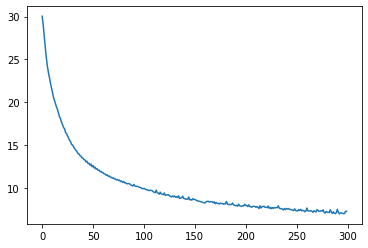

In [239]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X, y, epochs=300, batch_size=72, shuffle=False,verbose=0)
# plot history
plt.plot(history.history['loss'])
plt.show()

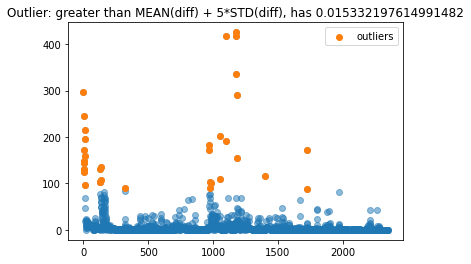

In [240]:
predicted = model.predict(X).reshape(-1)
diff = abs(predicted-y)
bar = np.mean(diff)+3*np.std(diff)
plt.scatter(range(len(diff)),diff,alpha=0.5)
plt.scatter(np.where(diff>bar), diff[np.where(diff>bar)],label='outliers')
plt.title(f'Outlier: greater than MEAN(diff) + 5*STD(diff), has {len(np.where(diff>bar)[0])/X.shape[0]}')
plt.legend()

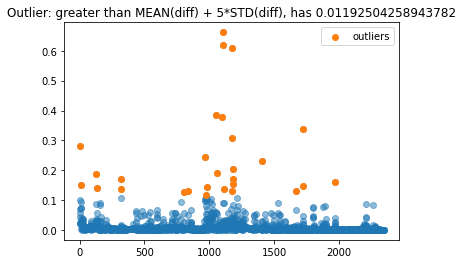

In [48]:
predicted = model.predict(X).reshape(-1)
diff = abs(predicted-y)
bar = np.mean(diff)+3*np.std(diff)
plt.scatter(range(len(diff)),diff,alpha=0.5)
plt.scatter(np.where(diff>bar), diff[np.where(diff>bar)],label='outliers')
plt.title(f'Outlier: greater than MEAN(diff) + 5*STD(diff), has {len(np.where(diff>bar)[0])/X.shape[0]}')
plt.legend()

plotting


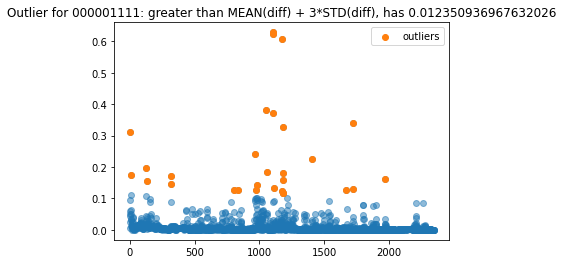

plotting


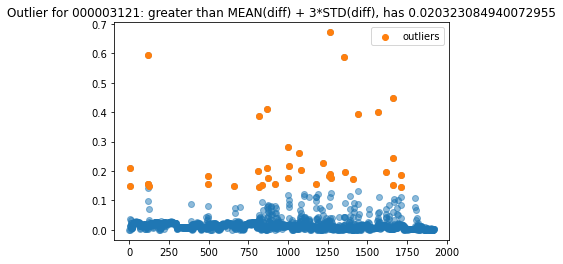

plotting


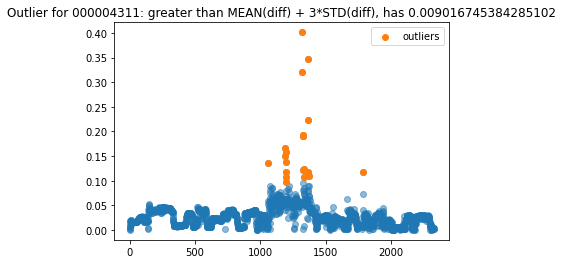

plotting


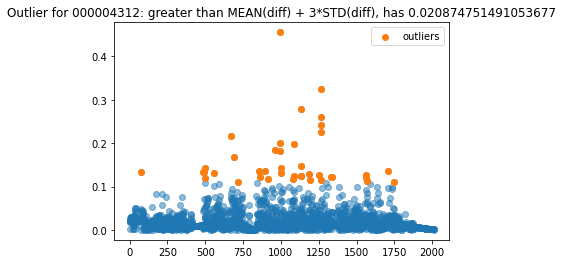

plotting


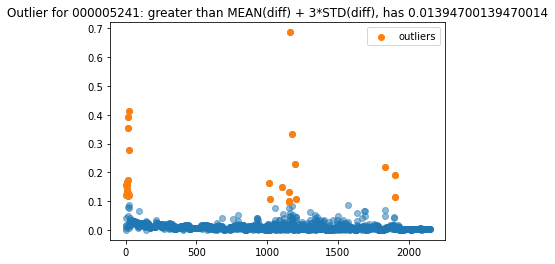

plotting


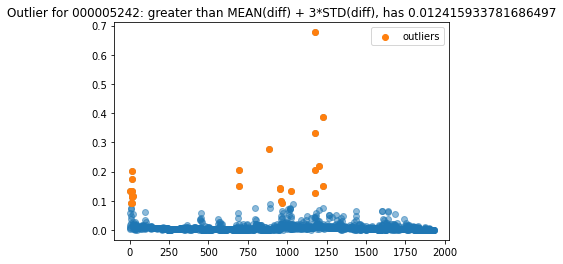

plotting


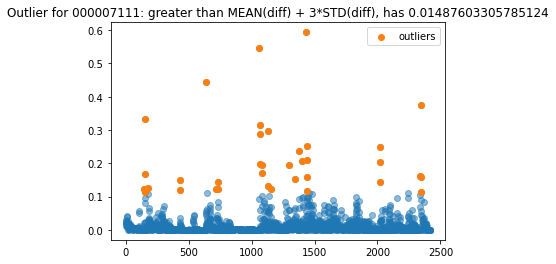

plotting


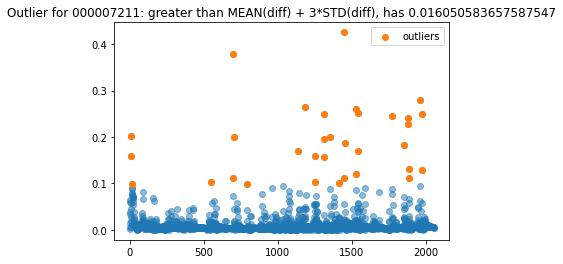

plotting


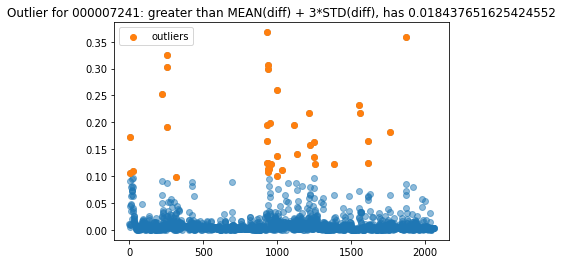

plotting


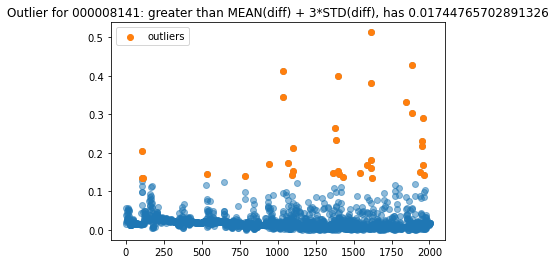

plotting


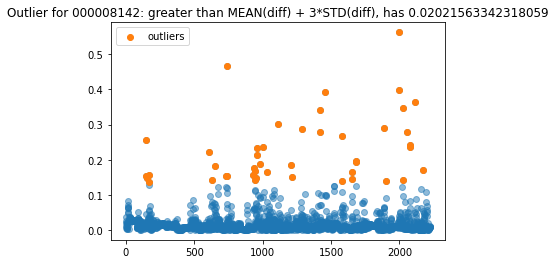

plotting


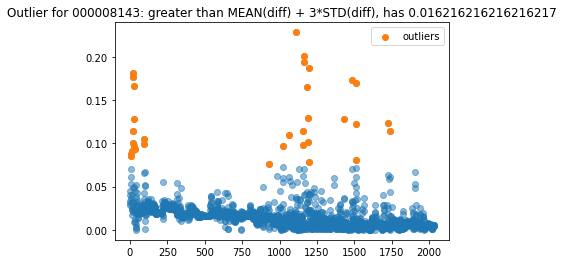

plotting


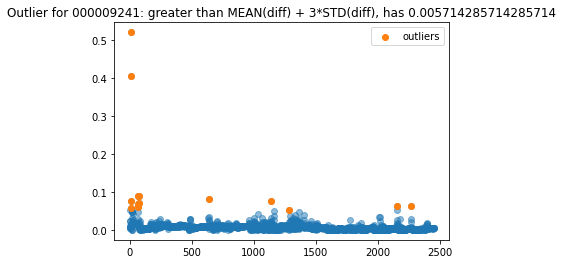

plotting


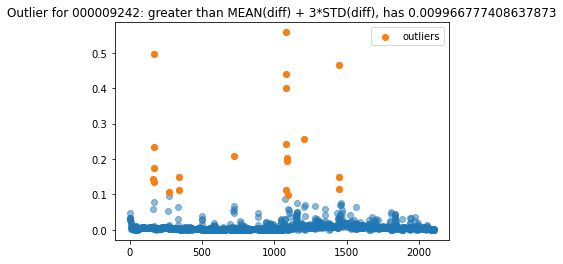

plotting


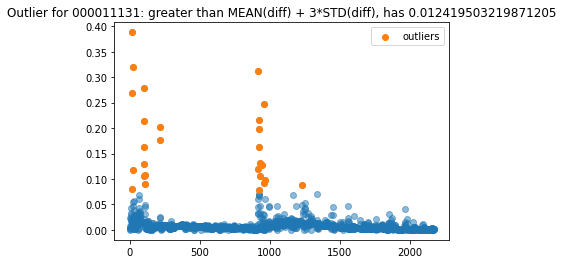

plotting


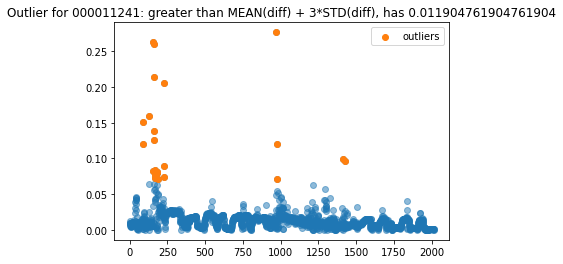

In [242]:
diff_percent = []
for record in T2B5:
    df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    df = df.dropna()
    df.drop(df.columns[[0,6]], axis=1, inplace=True)
    df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']]

    values = df.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, 1, 1)
    reframed.drop(reframed.columns[[5,6,7,8]], axis=1, inplace=True)
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    X = X.reshape((X.shape[0], 1, X.shape[1]))
    
#     train_model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    model.fit(X, y, epochs=50, batch_size=72, shuffle=False, verbose=0)
    
    predicted = model.predict(X).reshape(-1)
    diff = abs(predicted-y)
    bar = np.mean(diff)+3*np.std(diff)
    per = len(np.where(diff>bar)[0])/X.shape[0]
    diff_percent.append(per)
    print('plotting')
    plt.scatter(range(len(diff)),diff,alpha=0.5)
    plt.scatter(np.where(diff>bar), diff[np.where(diff>bar)],label='outliers')
    plt.title(f'Outlier for {record}: greater than MEAN(diff) + 3*STD(diff), has {per}')
    plt.legend()
    plt.show()

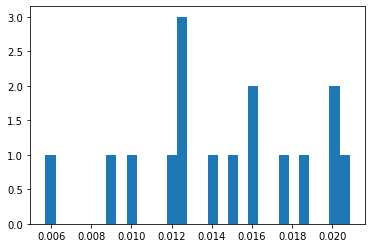

In [243]:
plt.hist(diff_percent, bins=30)
plt.show()

# No scaling

plotting


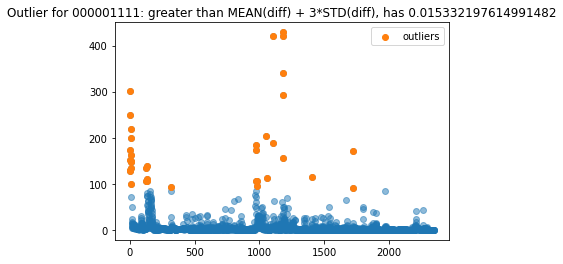

plotting


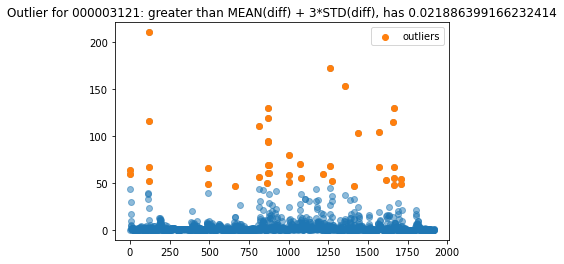

plotting


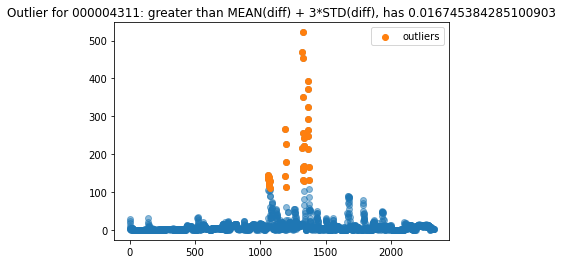

plotting


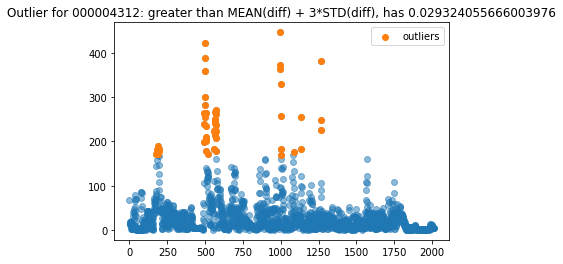

plotting


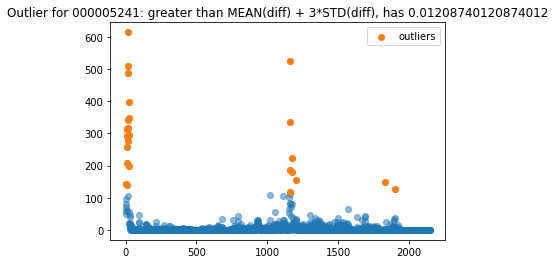

plotting


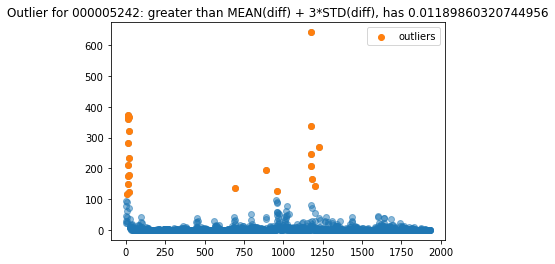

plotting


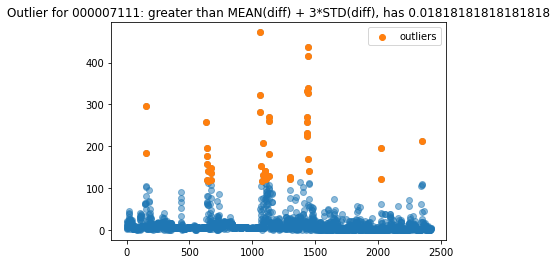

plotting


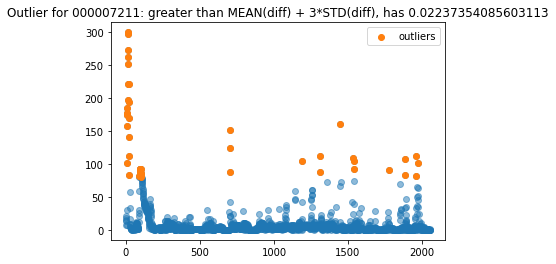

plotting


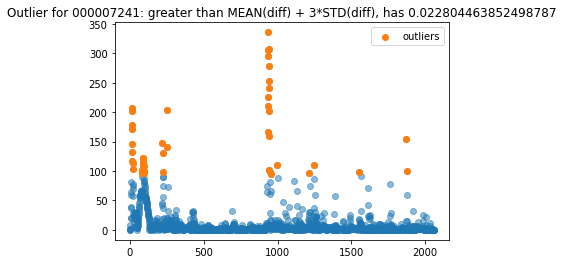

plotting


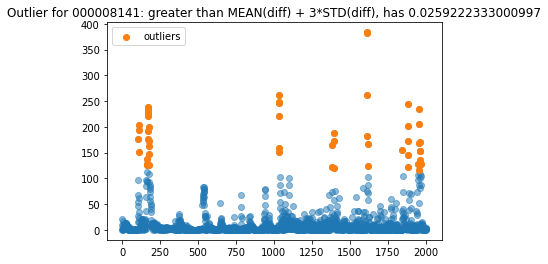

plotting


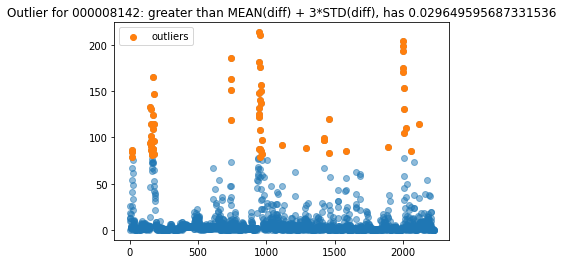

plotting


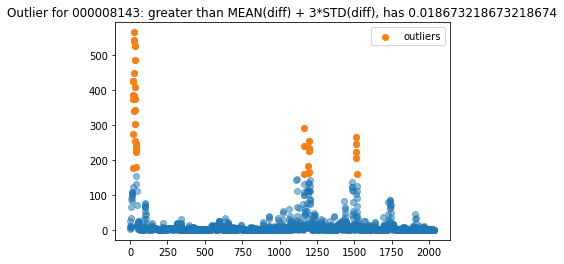

plotting


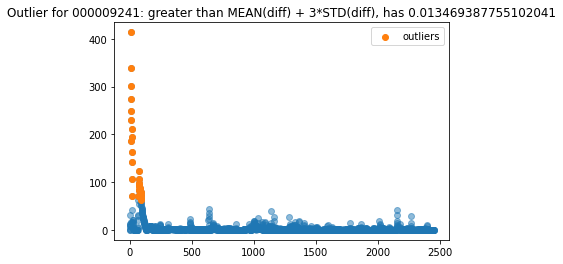

plotting


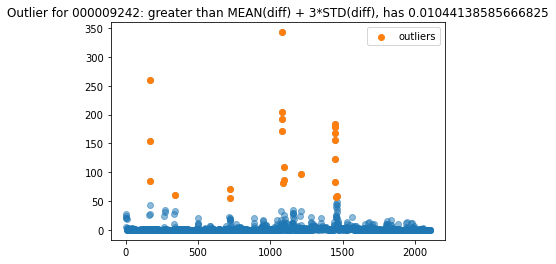

plotting


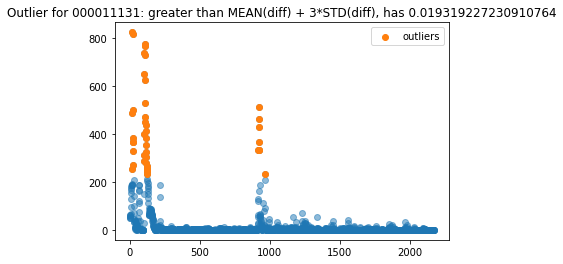

plotting


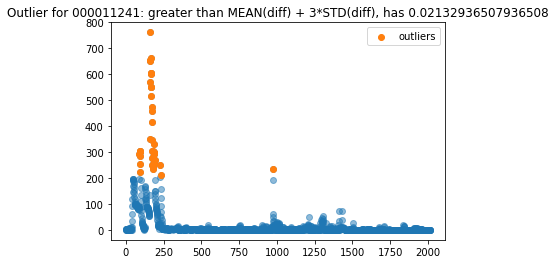

In [244]:
diff_percent = []
for record in T2B5:
    df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    df = df.dropna()
    df.drop(df.columns[[0,6]], axis=1, inplace=True)
    df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']]

    values = df.values
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaled = scaler.fit_transform(values)
    scaled = values
    reframed = series_to_supervised(scaled, 1, 1)
    reframed.drop(reframed.columns[[5,6,7,8]], axis=1, inplace=True)
    values = reframed.values
    X = values[:, :-1]
    y = values[:,-1]
    X = X.reshape((X.shape[0], 1, X.shape[1]))
    
#     train_model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    model.fit(X, y, epochs=300, batch_size=72, shuffle=False, verbose=0)
    
    predicted = model.predict(X).reshape(-1)
    diff = abs(predicted-y)
    bar = np.mean(diff)+3*np.std(diff)
    per = len(np.where(diff>bar)[0])/X.shape[0]
    diff_percent.append(per)
    print('plotting')
    plt.scatter(range(len(diff)),diff,alpha=0.5)
    plt.scatter(np.where(diff>bar), diff[np.where(diff>bar)],label='outliers')
    plt.title(f'Outlier for {record}: greater than MEAN(diff) + 3*STD(diff), has {per}')
    plt.legend()
    plt.show()

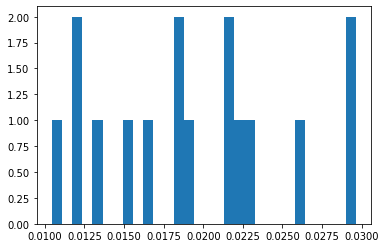

In [245]:
plt.hist(diff_percent, bins=30)
plt.show()

## Past two timestamps

In [199]:
example_df = example_df[['VS_km/h','VA','Lam','Texh_C','NOx_ppm']]
lag = 3
values = example_df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, lag, 1)
reframed.drop(reframed.columns[-5:-1], axis=1, inplace=True)

values = reframed.values
X = values[:, :-1]
y = values[:,-1]
X = X.reshape((X.shape[0], lag, -1))

In [200]:
X.shape,y.shape

((2346, 3, 5), (2346,))

In [204]:
reframed.describe()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var5(t)
count,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000
mean,0.374784,0.533667,0.032965,0.302111,0.062330,0.374784,0.533667,0.032939,0.302184,0.062127,0.374784,0.533667,0.032922,0.302256,0.061818,0.061552
std,0.272453,0.116576,0.085937,0.170251,0.078265,0.272453,0.116576,0.085933,0.170160,0.077743,0.272453,0.116576,0.085933,0.170069,0.076439,0.075475
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.112715,0.500066,0.011131,0.184499,0.020201,0.112715,0.500066,0.011131,0.184499,0.020201,0.112715,0.500066,0.011131,0.184499,0.020201,0.020201
50%,0.405793,0.533667,0.011627,0.274633,0.039501,0.405793,0.533667,0.011627,0.274633,0.039493,0.405793,0.533667,0.011627,0.274633,0.039380,0.039235
75%,0.511942,0.576155,0.014468,0.424074,0.076508,0.511942,0.576155,0.014468,0.424074,0.076457,0.511942,0.576155,0.014468,0.424074,0.076308,0.076283
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Epoch 1/60
33/33 [==============================] - 1s 16ms/step - loss: 0.0450
Epoch 2/60
33/33 [==============================] - 0s 15ms/step - loss: 0.0486
Epoch 3/60
33/33 [==============================] - 0s 14ms/step - loss: 0.0285
Epoch 4/60
33/33 [==============================] - 0s 14ms/step - loss: 0.0313
Epoch 5/60
33/33 [==============================] - 0s 15ms/step - loss: 0.0443
Epoch 6/60
33/33 [==============================] - 0s 15ms/step - loss: 0.0288
Epoch 7/60
33/33 [==============================] - 0s 15ms/step - loss: 0.0205
Epoch 8/60
33/33 [==============================] - 0s 14ms/step - loss: 0.0245
Epoch 9/60
33/33 [==============================] - 0s 15ms/step - loss: 0.0314
Epoch 10/60
33/33 [==============================] - 1s 15ms/step - loss: 0.0219
Epoch 11/60
33/33 [==============================] - 0s 15ms/step - loss: 0.0179
Epoch 12/60
33/33 [==============================] - 0s 14ms/step - loss: 0.0174
Epoch 13/60
33/33 [==================

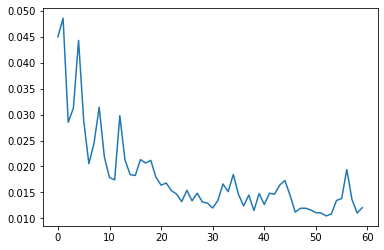

In [198]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X, y, epochs=60, batch_size=72, shuffle=False)
# plot history
plt.plot(history.history['loss'])
plt.show()

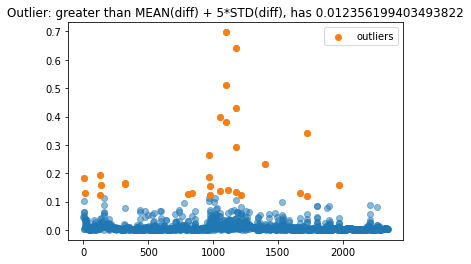

In [98]:
predicted = model.predict(X).reshape(-1)
diff = abs(predicted-y)
bar = np.mean(diff)+3*np.std(diff)
plt.scatter(range(len(diff)),diff,alpha=0.5)
plt.scatter(np.where(diff>bar), diff[np.where(diff>bar)],label='outliers')
plt.title(f'Outlier: greater than MEAN(diff) + 5*STD(diff), has {len(np.where(diff>bar)[0])/X.shape[0]}')
plt.legend()

# Leave one out valid

### Stack all examples for T2B5

In [350]:
df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', T2B5[0])
df = df.dropna()
df.drop(df.columns[[0,6]], axis=1, inplace=True)
df = df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']]
df['record'] = [T2B5[0]]*len(df)
for record in T2B5[1:]:
    new_df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    new_df = new_df.dropna()
    new_df.drop(new_df.columns[[0,6]], axis=1, inplace=True)
    new_df = new_df[['VS_km/h','Lam','Texh_C','VA','NOx_ppm']]
    new_df['record'] = [record]*len(new_df)
    df = pd.concat([df, new_df])
df = df.reset_index()
df.drop(columns=['index'],inplace=True)

### Training model

In [460]:
lag = 2
model = Sequential()
model.add(LSTM(50, input_shape=(lag, 5)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
performance = []

for record in T2B5:
    train_df = df[df.record!=record]
    test_df = df[df.record==record].iloc[:,0:5]
    
    for indv in train_df.record.unique():
        temp_df = train_df[train_df.record == indv].iloc[:,0:5]
        train_values = temp_df.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(train_values)
        reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
        values = reframed.values
        train_X = values[:, :-1]
        train_y = values[:,-1]
        train_X = train_X.reshape((train_X.shape[0], lag, -1))
        model.fit(train_X, train_y, epochs=50, batch_size=72, shuffle=False, verbose=0)

    test_values =test_df.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(test_values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
    test_X = values[:, :-1]
    test_X = test_X.reshape((test_X.shape[0], lag, -1))
    test_y = values[:, -1]
    
    score = model.evaluate(test_X, test_y, verbose = 0)
    performance.append((record, score))

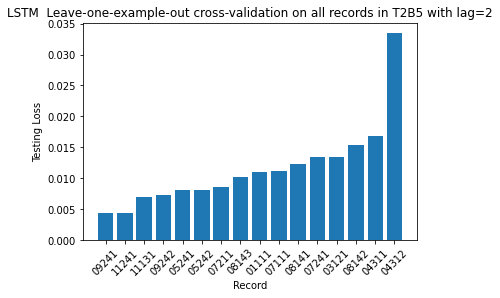

In [461]:
performance.sort(key = lambda i: i[1])
plt.bar([i[0][4:] for i in performance], [i[1] for i in performance])
plt.xticks(rotation=45)
plt.xlabel('Record')
plt.ylabel('Testing Loss')
plt.title('LSTM  Leave-one-example-out cross-validation on all records in T2B5 with lag=2')
plt.show()

### Retrain the model based on the best testing score

In [469]:
record = performance[0][0]
train_values = df[df.record!=record].iloc[:,0:5].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]
train_X = train_X.reshape((train_X.shape[0], lag, -1))

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
model.fit(train_X, train_y, epochs=50, batch_size=72, shuffle=False)


Epoch 1/50
442/442 [==============================] - 2s 5ms/step - loss: 0.0330
Epoch 2/50
442/442 [==============================] - 2s 5ms/step - loss: 0.0160
Epoch 3/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0106
Epoch 4/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0136
Epoch 5/50
442/442 [==============================] - 2s 5ms/step - loss: 0.0109
Epoch 6/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0096
Epoch 7/50
442/442 [==============================] - 2s 5ms/step - loss: 0.0097
Epoch 8/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0097
Epoch 9/50
442/442 [==============================] - 2s 5ms/step - loss: 0.0089
Epoch 10/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0082
Epoch 11/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0072
Epoch 12/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0084
Epoch 13/50
442/442 [====

### Generate outliers for each instance

plotting


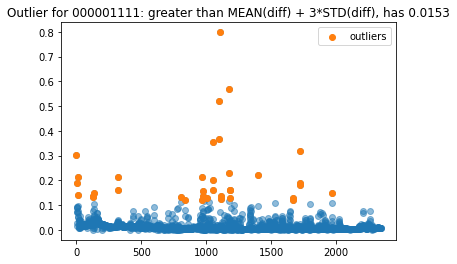

plotting


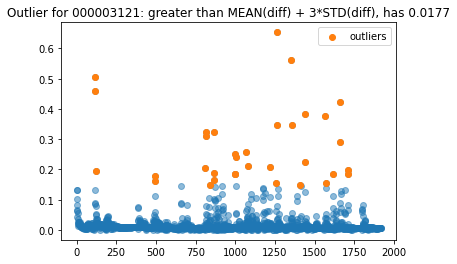

plotting


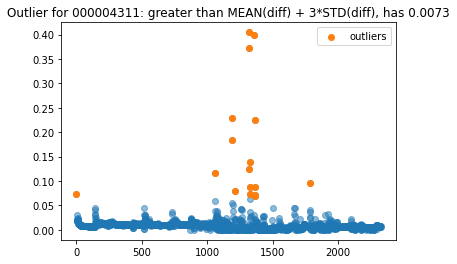

plotting


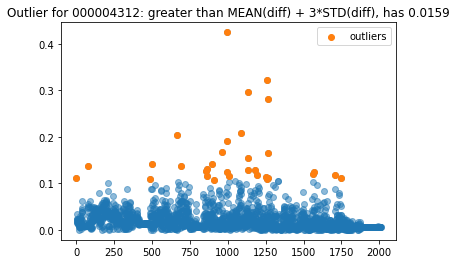

plotting


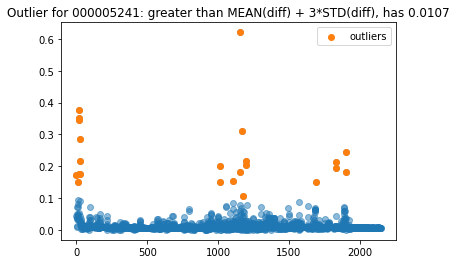

plotting


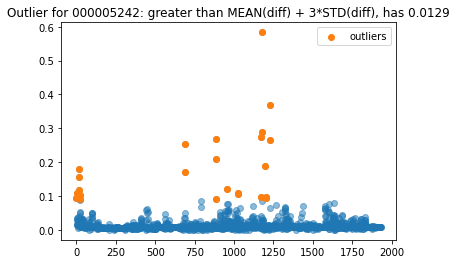

plotting


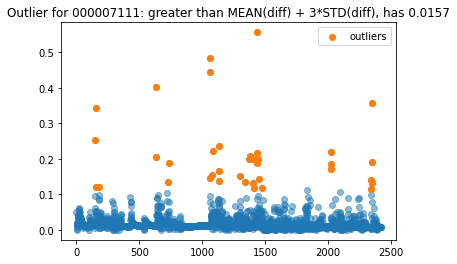

plotting


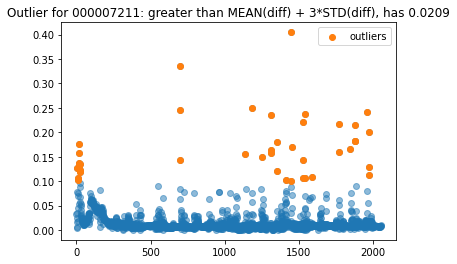

plotting


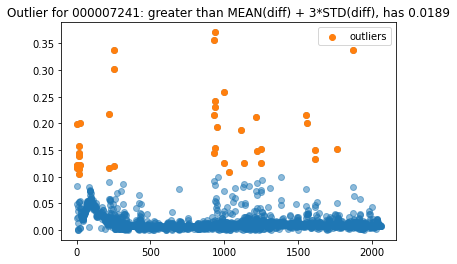

plotting


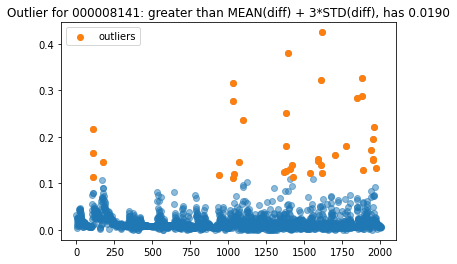

plotting


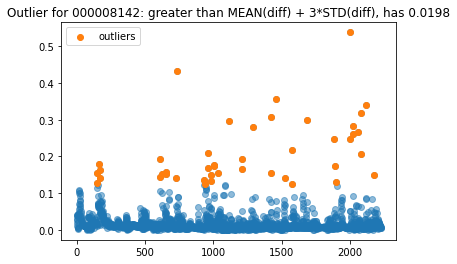

plotting


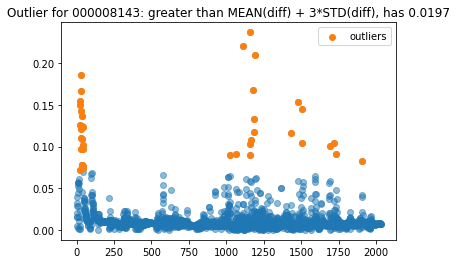

plotting


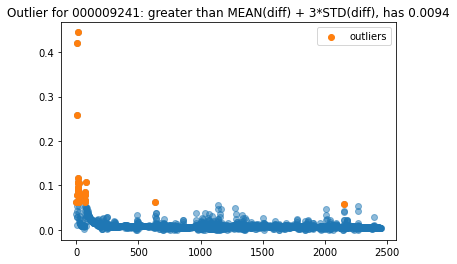

plotting


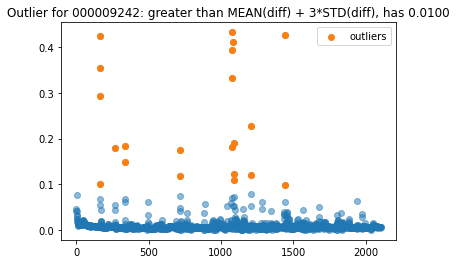

plotting


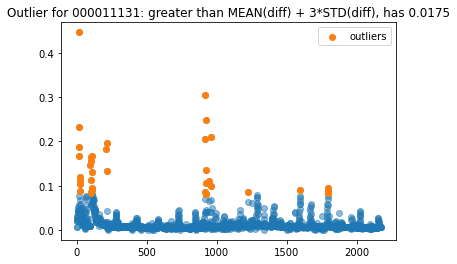

plotting


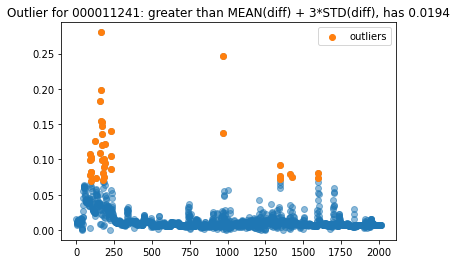

In [473]:
diff_percent = []
out_pos = []
for record in T2B5:
    values = df[df.record==record].iloc[:,0:5].values
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
        
    X = values[:, :-1]
    y = values[:,-1]
    X = X.reshape((X.shape[0], lag, -1))
    
    predicted = model.predict(X).reshape(-1)
    diff = abs(predicted-y)
    bar = np.mean(diff)+3*np.std(diff)
    outliers_pos = np.where(diff>bar)[0]
    out_pos.append((record, outliers_pos))
    per = len(outliers_pos)/X.shape[0]
    diff_percent.append(per)
    print('plotting')
    plt.scatter(range(len(diff)),diff,alpha=0.5)
    plt.scatter(outliers_pos, diff[outliers_pos],label='outliers', alpha=0.5)
    plt.title(f'Outlier for {record}: greater than MEAN(diff) + 3*STD(diff), has {per:.4f}')
    plt.legend()
    plt.show()

In [509]:
# Since the length of each example varies, we want to obtain the realtive outlier positions
rel_pos = []
for i in out_pos:
    length = len(df[df.record==i[0]])
    temp = [t/length for t in i[1]]
    rel_pos.append((i[0], temp))

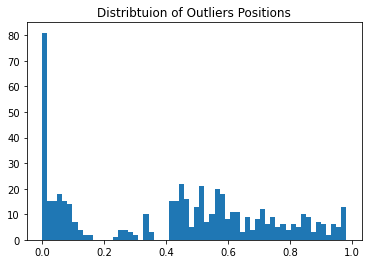

In [512]:
t = [i[1] for i in rel_pos]
plt.hist([item for sublist in t for item in sublist], bins=60)
plt.title('Distribtuion of Outliers Positions')
plt.show()

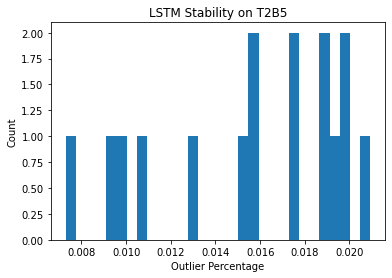

In [499]:
plt.hist(diff_percent, bins=30)
plt.xlabel('Outlier Percentage')
plt.ylabel('Count')
plt.title('LSTM Stability on T2B5')
plt.show()

In [372]:
model.save('LSTM')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: LSTM/assets


## Outlers for NOx_raw

In [518]:
df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', T2B5[0])
df = df.dropna()
df = df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']]
df['record'] = [T2B5[0]]*len(df)
for record in T2B5[1:]:
    new_df = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', record)
    new_df = new_df.dropna()
    new_df = new_df[['VS_km/h','Lam','Texh_C','VA','NOx_raw']]
    new_df['record'] = [record]*len(new_df)
    df = pd.concat([df, new_df])
df = df.reset_index()
df.drop(columns=['index'],inplace=True)

In [527]:
performance[0][0]

'000009241'

In [519]:
record = performance[0][0]
train_values = df[df.record!=record].iloc[:,0:5].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_values)
reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
values = reframed.values
train_X = values[:, :-1]
train_y = values[:,-1]
train_X = train_X.reshape((train_X.shape[0], lag, -1))

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
model.fit(train_X, train_y, epochs=50, batch_size=72, shuffle=False)

Epoch 1/50
442/442 [==============================] - 2s 5ms/step - loss: 0.0081
Epoch 2/50
442/442 [==============================] - 2s 5ms/step - loss: 0.0043
Epoch 3/50
442/442 [==============================] - 2s 5ms/step - loss: 0.0074
Epoch 4/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0078
Epoch 5/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0050
Epoch 6/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0061
Epoch 7/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0050
Epoch 8/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 9/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0050
Epoch 10/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 11/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0039
Epoch 12/50
442/442 [==============================] - 2s 4ms/step - loss: 0.0043
Epoch 13/50
442/442 [====

plotting


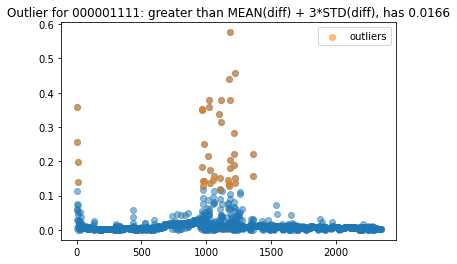

plotting


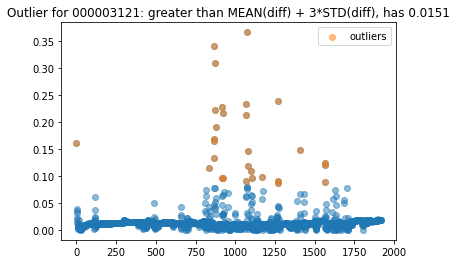

plotting


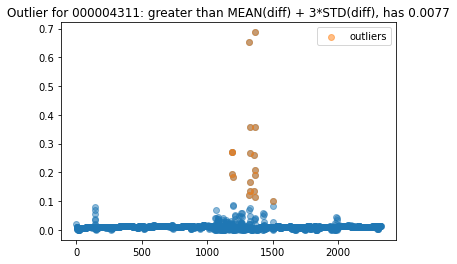

plotting


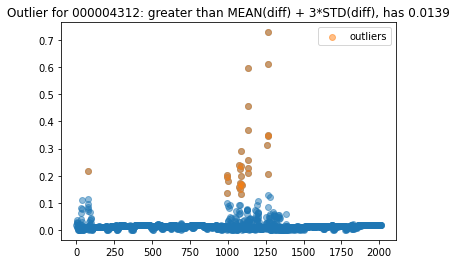

plotting


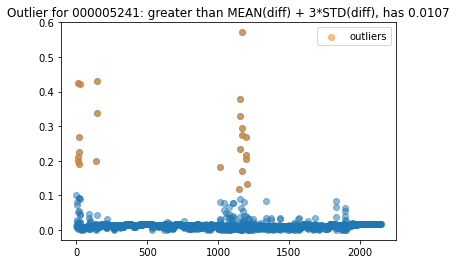

plotting


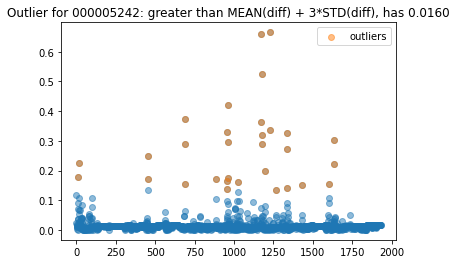

plotting


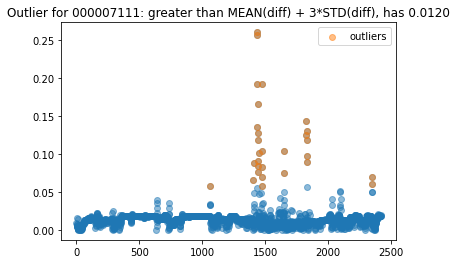

plotting


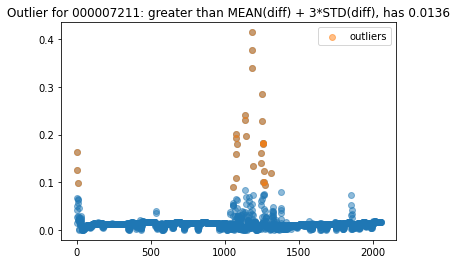

plotting


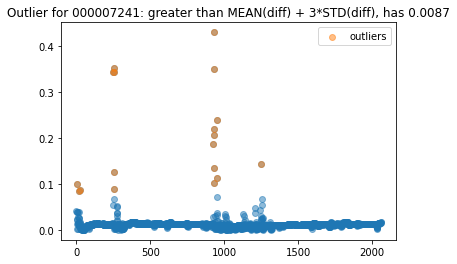

plotting


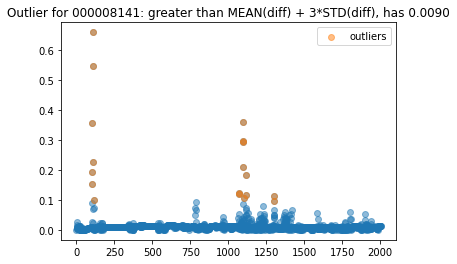

plotting


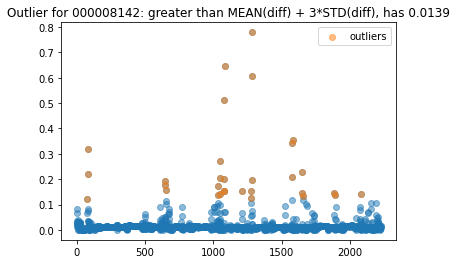

plotting


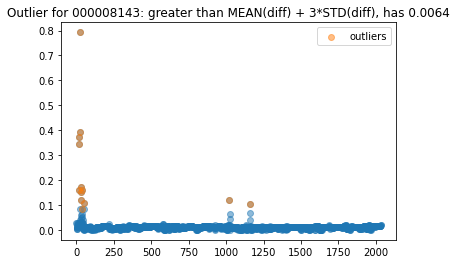

plotting


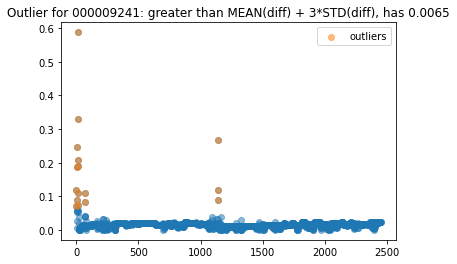

plotting


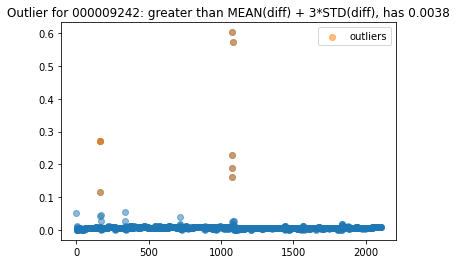

plotting


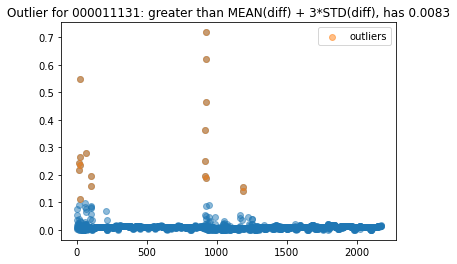

plotting


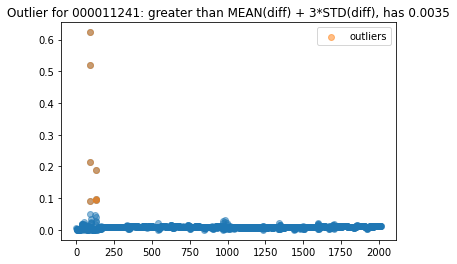

In [520]:
diff_percent = []
out_pos = []
for record in T2B5:
    values = df[df.record==record].iloc[:,0:5].values
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lag, 1).drop(columns=['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'])
    values = reframed.values
        
    X = values[:, :-1]
    y = values[:,-1]
    X = X.reshape((X.shape[0], lag, -1))
    
    predicted = model.predict(X).reshape(-1)
    diff = abs(predicted-y)
    bar = np.mean(diff)+3*np.std(diff)
    outliers_pos = np.where(diff>bar)[0]
    out_pos.append((record, outliers_pos))
    per = len(outliers_pos)/X.shape[0]
    diff_percent.append(per)
    print('plotting')
    plt.scatter(range(len(diff)),diff,alpha=0.5)
    plt.scatter(outliers_pos, diff[outliers_pos],label='outliers', alpha=0.5)
    plt.title(f'Outlier for {record}: greater than MEAN(diff) + 3*STD(diff), has {per:.4f}')
    plt.legend()
    plt.show()

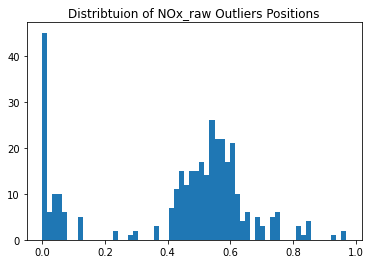

In [525]:
# Since the length of each example varies, we want to obtain the realtive outlier positions
rel_pos = []
for i in out_pos:
    length = len(df[df.record==i[0]])
    temp = [t/length for t in i[1]]
    rel_pos.append((i[0], temp))
    
t = [i[1] for i in rel_pos]
plt.hist([item for sublist in t for item in sublist], bins=60)
plt.title('Distribtuion of NOx_raw Outliers Positions')
plt.show()

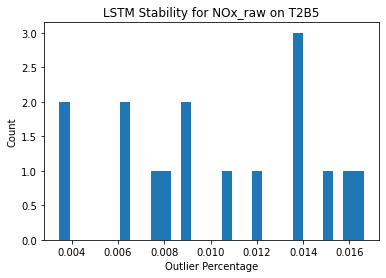

In [526]:
plt.hist(diff_percent, bins=30)
plt.xlabel('Outlier Percentage')
plt.ylabel('Count')
plt.title('LSTM Stability for NOx_raw on T2B5')
plt.show()